# Setup

In [1]:
# Cell 1 — Install dependencies
!pip install open_clip_torch transformers matplotlib seaborn grad-cam torchvision


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 69.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 62.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 38.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 91.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 61.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 43.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 19.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 3.2 MB/s e

In [ ]:
import os, glob, json, random
import numpy as np, pandas as pd
import cv2
import matplotlib.pyplot as plt, seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from PIL import Image
from tqdm.auto import tqdm
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, classification_report,
    roc_auc_score, roc_curve, confusion_matrix
)
import kagglehub
from open_clip import create_model_and_transforms, get_tokenizer
from open_clip.factory import HF_HUB_PREFIX, _MODEL_CONFIGS
from huggingface_hub import hf_hub_download
from torch.utils.data import Dataset, DataLoader

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [ ]:
df = pd.read_csv('filtered_oasis_1.csv')
cdr_map = {0.0:'Non-Demented',0.5:'Very Mild Dementia',1.0:'Mild Dementia',2.0:'Moderate Dementia',3.0:'Severe Dementia'}
df['CDR_Labels'] = df['CDR'].map(cdr_map)
unique_labels = sorted(df['CDR_Labels'].unique())
label2idx = {lab:i for i,lab in enumerate(unique_labels)}
df['label_idx'] = df['CDR_Labels'].map(label2idx)
print(f"Loaded {len(df)} rows; classes = {unique_labels}")

BASE_PATH = kagglehub.dataset_download("ninadaithal/imagesoasis")
all_jpgs  = glob.glob(f"{BASE_PATH}/**/*.jpg", recursive=True)
mpr1      = [p for p in all_jpgs if '_mpr-1_' in os.path.basename(p).lower()]
print(f"Found {len(mpr1)} MPR-1 images")

id_to_images = {}
for p in mpr1:
    pid = os.path.basename(p).split('_mpr-1_')[0]
    id_to_images.setdefault(pid, []).append(p)
for pid in id_to_images: id_to_images[pid].sort()
print(f"{len(id_to_images)} unique patient IDs")

df = df[df['ID'].isin(id_to_images)].reset_index(drop=True)
df['image_path'] = df['ID'].map(lambda pid: id_to_images[pid][len(id_to_images[pid])//2] if pid in id_to_images else None)
df = df.dropna(subset=['image_path']).reset_index(drop=True)
print(f"After selecting middle slice: {len(df)} rows")

neighbors = {label2idx['Mild Dementia']:3, label2idx['Very Mild Dementia']:1, label2idx['Moderate Dementia']:9}
aug = []
for _,r in df.iterrows():
    pid,lab,imgs = r['ID'],r['label_idx'],id_to_images[r['ID']]
    mid = len(imgs)//2; n = neighbors.get(lab,0)
    for o in range(-n,n+1):
        i = mid+o
        if 0<=i<len(imgs):
            nr = r.copy(); nr['image_path']=imgs[i]; aug.append(nr)
df_aug = pd.DataFrame(aug).reset_index(drop=True)
print("Augmented counts:\n",df_aug['CDR_Labels'].value_counts())
score_context = {
    'MMSE': "MMSE (Mini-Mental State Examination) is a cognitive assessment used to evaluate cognitive function. A score of 24-30 indicates normal cognitive function, while scores below 24 suggest cognitive impairment.",
    'eTIV': "eTIV (estimated Total Intracranial Volume) measures the volume of the skull, which is related to brain size. The normal range varies based on age and sex, but it's generally around 1400-1600 cm^3.",
    'nWBV': "nWBV (normalized Whole Brain Volume) is the proportion of the brain's volume relative to the total intracranial volume. A higher percentage generally suggests better brain health, with a range from ~70% to 85%.",
    'ASF':  "ASF (Atlas Scaling Factor) adjusts the image to match a reference template. Values around 1 indicate good alignment, while values significantly higher or lower may indicate problems with the scaling or registration process.",
    'CDR':  "CDR (Clinical Dementia Rating) is used to assess the severity of dementia. A score of 0 indicates no dementia, 0.5 suggests very mild dementia, 1 indicates mild dementia, 2 indicates moderate dementia, and 3 indicates severe dementia."
}

def handle_missing_value(value):
    if pd.isna(value) or value == -1:
        return "Information unavailable."
    return str(value)

def generate_caption(row):
    return (
        f"Patient ID: {row['ID']},\n"
        f"Gender: {row['M/F']}, Handedness: {row['Hand']}, Age: {row['Age']} years,\n"
        f"Education: {handle_missing_value(row['Educ'])},\n"
        f"Socioeconomic Status: {handle_missing_value(row['SES'])},\n"
        f"MMSE: {handle_missing_value(row['MMSE'])} ({score_context['MMSE']}),\n"
        f"eTIV: {handle_missing_value(row['eTIV'])} ({score_context['eTIV']}),\n"
        f"nWBV: {handle_missing_value(row['nWBV'])} ({score_context['nWBV']}),\n"
        f"ASF: {handle_missing_value(row['ASF'])} ({score_context['ASF']}),\n"
        f"CDR: {handle_missing_value(row['CDR'])} ({score_context['CDR']})."
    )

df_aug['CustomCaption'] = df_aug.apply(generate_caption, axis=1)

label2idx = {lab:i for i,lab in enumerate(sorted(df_aug['CDR_Labels'].unique()))}
df_aug['label_idx'] = df_aug['CDR_Labels'].map(label2idx)
num_classes = len(label2idx)
train_df,val_df = train_test_split(df_aug, stratify=df_aug['label_idx'], test_size=0.2, random_state=42)
print(f"Train {len(train_df)}, Val {len(val_df)}")


Loaded 366 rows; classes = ['Mild Dementia', 'Moderate Dementia', 'Non-Demented', 'Very Mild Dementia']
Found 22265 MPR-1 images
365 unique patient IDs
After selecting middle slice: 365 rows
Augmented counts:
 CDR_Labels
Non-Demented          284
Very Mild Dementia    174
Mild Dementia         147
Moderate Dementia      38
Name: count, dtype: int64
Train 514, Val 129


In [ ]:
for subset in (train_df, val_df):
    if 'CustomCaption' in subset.columns:
        subset['CustomCaption'] = subset['CustomCaption'].fillna('').astype(str)
    else:
        subset['CustomCaption'] = ''
print("Train CustomCaption samples:", train_df['CustomCaption'].head(2).tolist())


Train CustomCaption samples: ["Patient ID: OAS1_0345_MR1,\nGender: F, Handedness: R, Age: 54 years,\nEducation: 4.0,\nSocioeconomic Status: 2.0,\nMMSE: 30.0 (MMSE (Mini-Mental State Examination) is a cognitive assessment used to evaluate cognitive function. A score of 24-30 indicates normal cognitive function, while scores below 24 suggest cognitive impairment.),\neTIV: 1389 (eTIV (estimated Total Intracranial Volume) measures the volume of the skull, which is related to brain size. The normal range varies based on age and sex, but it's generally around 1400-1600 cm^3.),\nnWBV: 0.831 (nWBV (normalized Whole Brain Volume) is the proportion of the brain's volume relative to the total intracranial volume. A higher percentage generally suggests better brain health, with a range from ~70% to 85%.),\nASF: 1.264 (ASF (Atlas Scaling Factor) adjusts the image to match a reference template. Values around 1 indicate good alignment, while values significantly higher or lower may indicate problems 

In [ ]:
hf_hub_download(
    repo_id="microsoft/BiomedCLIP-PubMedBERT_256-vit_base_patch16_224",
    filename="open_clip_pytorch_model.bin",
    local_dir="checkpoints"
)
hf_hub_download(
    repo_id="microsoft/BiomedCLIP-PubMedBERT_256-vit_base_patch16_224",
    filename="open_clip_config.json",
    local_dir="checkpoints"
)

model_name = "biomedclip_local"
with open("checkpoints/open_clip_config.json", "r") as f:
    cfg = json.load(f)
    model_cfg      = cfg["model_cfg"]
    preprocess_cfg = cfg["preprocess_cfg"]

from open_clip.factory import HF_HUB_PREFIX, _MODEL_CONFIGS
if not model_name.startswith(HF_HUB_PREFIX) and model_name not in _MODEL_CONFIGS:
    _MODEL_CONFIGS[model_name] = model_cfg

model, _, preprocess = create_model_and_transforms(
    model_name=model_name,
    pretrained="checkpoints/open_clip_pytorch_model.bin",
    **{f"image_{k}": v for k, v in preprocess_cfg.items()}
)
tokenizer = get_tokenizer(model_name)
model = model.to(device)


In [ ]:
def process_image(image_path, preprocess, device, show = False):
    original = Image.open(image_path)
    image = cv2.cvtColor(np.array(original), cv2.COLOR_RGB2BGR)
    image = cv2.resize(image, (224, 224))
    rotated = cv2.rotate(image, cv2.ROTATE_90_CLOCKWISE)
    processed = Image.fromarray(cv2.cvtColor(rotated, cv2.COLOR_BGR2RGB))
    image_input = preprocess(processed)

    return image_input
class DementiaDS(Dataset):
    def __init__(self, df):
        self.df = df.reset_index(drop=True)
    def __len__(self):
        return len(self.df)
    def __getitem__(self, i):
        r = self.df.iloc[i]
        img = process_image(r['image_path'], preprocess, device)
        img = img.to(device) 
        txt = tokenizer([r['CustomCaption']]).squeeze(0).to(device)
        lbl = torch.tensor(r['label_idx'], dtype=torch.long)
        return img, txt, lbl

train_ds     = DementiaDS(train_df)
val_ds       = DementiaDS(val_df)
train_loader = DataLoader(train_ds, batch_size=1, shuffle=True,  num_workers=0)
val_loader   = DataLoader(val_ds,   batch_size=1, shuffle=False, num_workers=0)


In [ ]:
print("Aug dataset:",Counter(df_aug['label_idx']))
print("Train batches:",len(train_loader),"Val batches:",len(val_loader))


Aug dataset: Counter({2: 284, 3: 174, 0: 147, 1: 38})
Train batches: 514 Val batches: 129


In [ ]:
for p in model.parameters(): p.requires_grad=False
for blk in model.visual.trunk.blocks[-2:]:
    for p in blk.parameters(): p.requires_grad=True
for p in model.visual.head.parameters(): p.requires_grad=True

classifier = nn.Sequential(
    nn.Linear(512+512,256), nn.ReLU(), nn.Dropout(0.3),
    nn.Linear(256,num_classes)
).to(device)


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(
    list(filter(lambda p:p.requires_grad, model.parameters())) +
    list(classifier.parameters()),
    lr=1e-5
)


In [ ]:
orig_losses,orig_accs = [],[]
for ep in range(1,11):
    model.train(); classifier.train()
    tot=0
    for imgs,txts,labels in tqdm(train_loader,desc=f"Orig Ep{ep}"):
        optimizer.zero_grad()
        ie,te = model.encode_image(imgs), model.encode_text(txts)
        logits= classifier(torch.cat([ie,te],1))
        loss  = criterion(logits,labels.to(device))
        loss.backward(); optimizer.step()
        tot+=loss.item()
    orig_losses.append(tot/len(train_loader))
    model.eval(); classifier.eval()
    corr=0
    with torch.no_grad():
        for imgs,txts,labels in val_loader:
            ie,te = model.encode_image(imgs),model.encode_text(txts)
            preds = classifier(torch.cat([ie,te],1)).argmax(1)
            corr += (preds==labels.to(device)).sum().item()
    acc = corr/len(val_loader)
    orig_accs.append(acc)
    print(f"Orig Ep{ep}: loss={orig_losses[-1]:.4f}, acc={acc:.2%}")

Orig Ep1:   0%|          | 0/514 [00:00<?, ?it/s]

Orig Ep1: loss=1.0864, acc=51.16%


Orig Ep2:   0%|          | 0/514 [00:00<?, ?it/s]

Orig Ep2: loss=0.7585, acc=71.32%


Orig Ep3:   0%|          | 0/514 [00:00<?, ?it/s]

Orig Ep3: loss=0.4826, acc=79.07%


Orig Ep4:   0%|          | 0/514 [00:00<?, ?it/s]

Orig Ep4: loss=0.2370, acc=83.72%


Orig Ep5:   0%|          | 0/514 [00:00<?, ?it/s]

Orig Ep5: loss=0.0969, acc=86.82%


Orig Ep6:   0%|          | 0/514 [00:00<?, ?it/s]

Orig Ep6: loss=0.0297, acc=84.50%


Orig Ep7:   0%|          | 0/514 [00:00<?, ?it/s]

Orig Ep7: loss=0.0101, acc=86.82%


Orig Ep8:   0%|          | 0/514 [00:00<?, ?it/s]

Orig Ep8: loss=0.0036, acc=83.72%


Orig Ep9:   0%|          | 0/514 [00:00<?, ?it/s]

Orig Ep9: loss=0.0021, acc=86.05%


Orig Ep10:   0%|          | 0/514 [00:00<?, ?it/s]

Orig Ep10: loss=0.0014, acc=85.27%


# Finetuning BioMedCLIP on Multiclass Classification (Results)


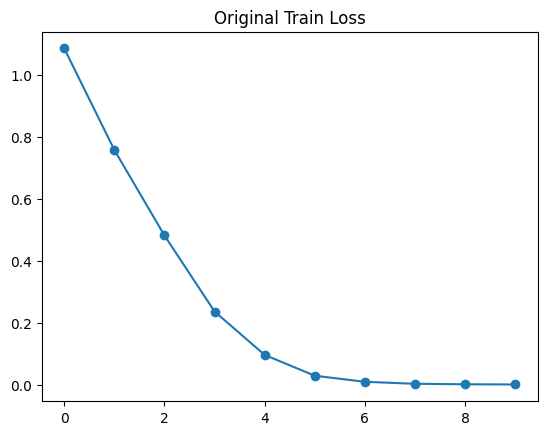

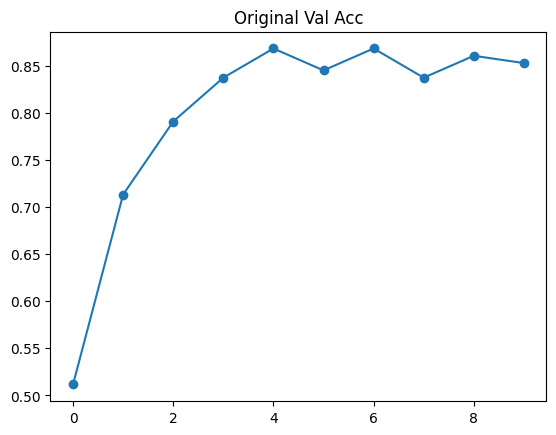

In [ ]:
plt.figure(); plt.plot(orig_losses,marker='o'); plt.title("Original Train Loss"); plt.show()
plt.figure(); plt.plot(orig_accs,marker='o'); plt.title("Original Val Acc"); plt.show()


Confusion Matrix (Baseline):
[[18  0  0 11]
 [ 0  6  1  1]
 [ 7 13  0 37]
 [ 6  0  0 29]]

Confusion Matrix (Finetuned):
[[27  1  0  1]
 [ 0  7  0  1]
 [ 2  0 46  9]
 [ 0  0  5 30]]

--- Comparative Results ---
Vanilla BioMedCLIP: Accuracy = 0.4109, AUC = 0.7032
Finetuned Model:    Accuracy = 0.8527, AUC = 0.9654

Per-Class Accuracy Comparison:
                Class  Baseline Accuracy  Finetuned Accuracy
0       Mild Dementia           0.620690            0.931034
1   Moderate Dementia           0.750000            0.875000
2        Non-Demented           0.000000            0.807018
3  Very Mild Dementia           0.828571            0.857143


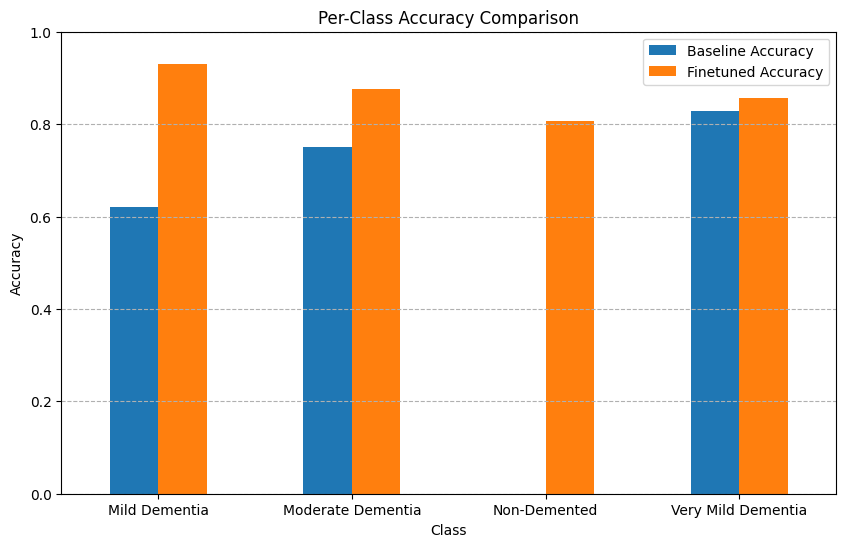

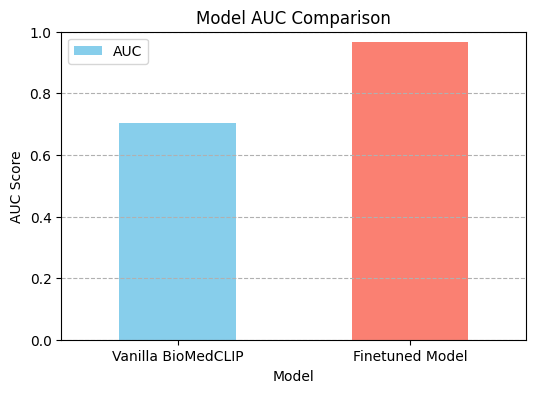

In [ ]:

from sklearn.metrics import accuracy_score, confusion_matrix
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def safe_auc(y_true, y_prob):
    from sklearn.metrics import roc_auc_score
    aucs = []
    for i in range(num_classes):
        y_i = (y_true == i).astype(int)
        p_i = y_prob[:, i]
        if y_i.sum() > 0 and y_i.sum() < len(y_i):
            aucs.append(roc_auc_score(y_i, p_i))
    return float(np.mean(aucs)) if aucs else 0.0

prompts       = [f"A medical expert looking to assess for a neuro-degenerative disease would likely classify this as {lab}."
                 for lab in unique_labels]
prompt_tokens = tokenizer(prompts).to(device)
with torch.no_grad():
    prompt_embs = model.encode_text(prompt_tokens)

all_y, all_pred, all_prob = [], [], []
model.eval()
with torch.no_grad():
    for images, _, labels in val_loader:
        images = images.to(device)
        emb_i  = model.encode_image(images)
        sims   = (emb_i @ prompt_embs.T) * model.logit_scale.exp()
        probs  = sims.softmax(dim=1).cpu().numpy()
        preds  = probs.argmax(axis=1)

        all_y   .extend(labels.numpy())
        all_pred.extend(preds)
        all_prob.extend(probs)

y_true  = np.array(all_y)
y_pred  = np.array(all_pred)
y_prob  = np.vstack(all_prob)

baseline_acc = accuracy_score(y_true, y_pred)
baseline_auc = safe_auc(y_true, y_prob)
baseline_cm  = confusion_matrix(y_true, y_pred, labels=np.arange(num_classes))

all_y2, all_pred2, all_prob2 = [], [], []
model.eval(); classifier.eval()
with torch.no_grad():
    for images, captions, labels in val_loader:
        images, captions = images.to(device), captions.to(device)
        emb_i  = model.encode_image(images)
        emb_t  = model.encode_text(captions)
        logits = classifier(torch.cat([emb_i, emb_t], dim=1))
        probs  = logits.softmax(dim=1).cpu().numpy()
        preds  = probs.argmax(axis=1)

        all_y2   .extend(labels.numpy())
        all_pred2.extend(preds)
        all_prob2.extend(probs)

y_true2  = np.array(all_y2)
y_pred2  = np.array(all_pred2)
y_prob2  = np.vstack(all_prob2)

finetuned_acc = accuracy_score(y_true2, y_pred2)
finetuned_auc = safe_auc(y_true2, y_prob2)
finetuned_cm  = confusion_matrix(y_true2, y_pred2, labels=np.arange(num_classes))

print("Confusion Matrix (Baseline):")
print(baseline_cm)
print("\nConfusion Matrix (Finetuned):")
print(finetuned_cm)

print("\n--- Comparative Results ---")
print(f"Vanilla BioMedCLIP: Accuracy = {baseline_acc:.4f}, AUC = {baseline_auc:.4f}")
print(f"Finetuned Model:    Accuracy = {finetuned_acc:.4f}, AUC = {finetuned_auc:.4f}")

base_cls_acc  = baseline_cm.diagonal() / baseline_cm.sum(axis=1)
tuned_cls_acc = finetuned_cm.diagonal() / finetuned_cm.sum(axis=1)
comparison_df = pd.DataFrame({
    'Class': unique_labels,
    'Baseline Accuracy': base_cls_acc,
    'Finetuned Accuracy': tuned_cls_acc
})
print("\nPer-Class Accuracy Comparison:")
print(comparison_df)

ax = comparison_df.plot(
    x='Class',
    y=['Baseline Accuracy', 'Finetuned Accuracy'],
    kind='bar',
    figsize=(10,6)
)
ax.set_ylabel('Accuracy')
ax.set_title('Per-Class Accuracy Comparison')
ax.set_ylim(0,1)
ax.grid(True, axis='y', linestyle='--')
plt.xticks(rotation=0)
plt.show()

auc_df = pd.DataFrame({
    'Model': ['Vanilla BioMedCLIP', 'Finetuned Model'],
    'AUC':   [baseline_auc, finetuned_auc]
})
ax = auc_df.plot(
    x='Model',
    y='AUC',
    kind='bar',
    figsize=(6,4),
    color=['skyblue','salmon']
)
ax.set_ylabel('AUC Score')
ax.set_title('Model AUC Comparison')
ax.set_ylim(0,1)
ax.grid(True, axis='y', linestyle='--')
plt.xticks(rotation=0)
plt.show()


In [ ]:
import torchvision.models as models
vgg = models.vgg16(pretrained=True).to(device)
for p in vgg.parameters(): p.requires_grad=False
for layer in vgg.features[24:]:
    for p in layer.parameters(): p.requires_grad=True

image_proj = nn.Sequential(
    nn.AdaptiveAvgPool2d((1,1)), nn.Flatten(),
    nn.Linear(512,512), nn.ReLU()
).to(device)

classifier_vgg = nn.Sequential(
    nn.Linear(512+512,256), nn.ReLU(), nn.Dropout(0.3),
    nn.Linear(256,num_classes)
).to(device)

opt_vgg = optim.Adam(
    list(filter(lambda p:p.requires_grad, vgg.parameters())) +
    list(image_proj.parameters()) +
    list(classifier_vgg.parameters()),
    lr=1e-5
)
crit = nn.CrossEntropyLoss()


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:02<00:00, 228MB/s]


In [ ]:
vgg_losses,vgg_accs=[],[]
for ep in range(1,11):
    vgg.train(); image_proj.train(); classifier_vgg.train()
    tot=0
    for imgs,txts,labels in tqdm(train_loader,desc=f"VGG Ep{ep}"):
        opt_vgg.zero_grad()
        feats = vgg.features(imgs)
        pooled= vgg.avgpool(feats)
        ie    = image_proj(pooled)
        te    = model.encode_text(txts)
        logits= classifier_vgg(torch.cat([ie,te],1))
        loss  = crit(logits,labels.to(device))  
        loss.backward(); opt_vgg.step()
        tot+=loss.item()
    vgg_losses.append(tot/len(train_loader))
    vgg.eval();image_proj.eval();classifier_vgg.eval()
    corr=0
    with torch.no_grad():
        for imgs,txts,labels in val_loader:
            feats= vgg.features(imgs)
            pooled=vgg.avgpool(feats)
            ie   = image_proj(pooled)
            te   = model.encode_text(txts)
            preds=classifier_vgg(torch.cat([ie,te],1)).argmax(1)
            corr+=(preds==labels.to(device)).sum().item()  
    acc=corr/len(val_loader); vgg_accs.append(acc)
    print(f"VGG Ep{ep}: loss={vgg_losses[-1]:.4f}, acc={acc:.2%}")

VGG Ep1:   0%|          | 0/514 [00:00<?, ?it/s]

VGG Ep1: loss=1.2232, acc=44.19%


VGG Ep2:   0%|          | 0/514 [00:00<?, ?it/s]

VGG Ep2: loss=0.9904, acc=58.14%


VGG Ep3:   0%|          | 0/514 [00:00<?, ?it/s]

VGG Ep3: loss=0.8043, acc=65.89%


VGG Ep4:   0%|          | 0/514 [00:00<?, ?it/s]

VGG Ep4: loss=0.6722, acc=62.02%


VGG Ep5:   0%|          | 0/514 [00:00<?, ?it/s]

VGG Ep5: loss=0.5670, acc=70.54%


VGG Ep6:   0%|          | 0/514 [00:00<?, ?it/s]

VGG Ep6: loss=0.4841, acc=77.52%


VGG Ep7:   0%|          | 0/514 [00:00<?, ?it/s]

VGG Ep7: loss=0.3990, acc=75.19%


VGG Ep8:   0%|          | 0/514 [00:00<?, ?it/s]

VGG Ep8: loss=0.3408, acc=75.97%


VGG Ep9:   0%|          | 0/514 [00:00<?, ?it/s]

VGG Ep9: loss=0.2831, acc=82.95%


VGG Ep10:   0%|          | 0/514 [00:00<?, ?it/s]

VGG Ep10: loss=0.2254, acc=75.19%


# Finetuning BioMedCLIP (Vision Head Swapped with VGG-16) on Multiclass Classification (Results)


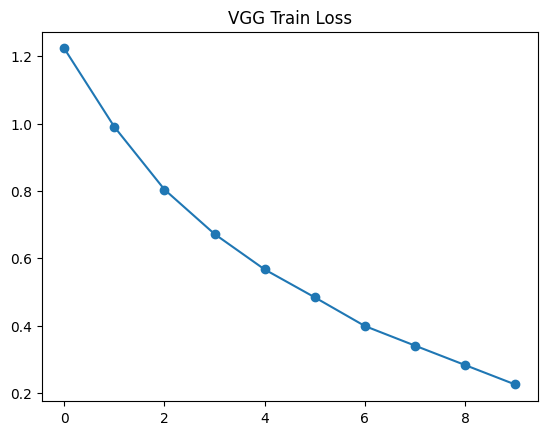

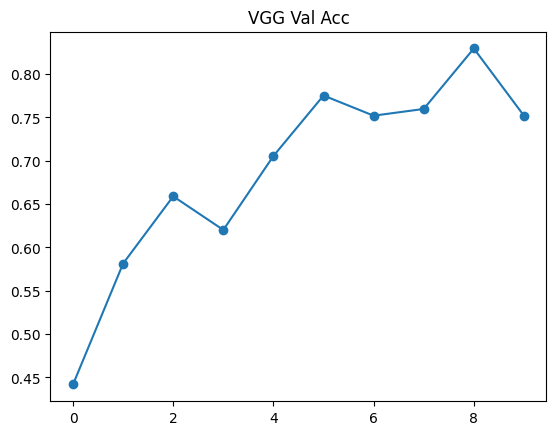

In [ ]:
plt.figure(); plt.plot(vgg_losses,marker='o'); plt.title("VGG Train Loss"); plt.show()
plt.figure(); plt.plot(vgg_accs,marker='o'); plt.title("VGG Val Acc"); plt.show()


Confusion Matrix (Baseline CLIP prompts):
[[18  0  0 11]
 [ 0  6  1  1]
 [ 7 13  0 37]
 [ 6  0  0 29]] 

Confusion Matrix (Finetuned CLIP):
[[27  1  0  1]
 [ 0  7  0  1]
 [ 2  0 46  9]
 [ 0  0  5 30]] 

Confusion Matrix (VGG-Finetuned):
[[26  0  1  2]
 [ 2  6  0  0]
 [ 2  0 49  6]
 [ 6  0 13 16]] 

--- Comparative Results ---
Baseline CLIP:    Accuracy = 0.4109, AUC = 0.7032
Finetuned CLIP:   Accuracy = 0.8527, AUC = 0.9654
VGG-Finetuned:    Accuracy = 0.7519, AUC = 0.9517

Per-Class Accuracy Comparison:
                Class  Baseline  Finetuned CLIP  VGG-Finetuned
0       Mild Dementia  0.620690        0.931034       0.896552
1   Moderate Dementia  0.750000        0.875000       0.750000
2        Non-Demented  0.000000        0.807018       0.859649
3  Very Mild Dementia  0.828571        0.857143       0.457143


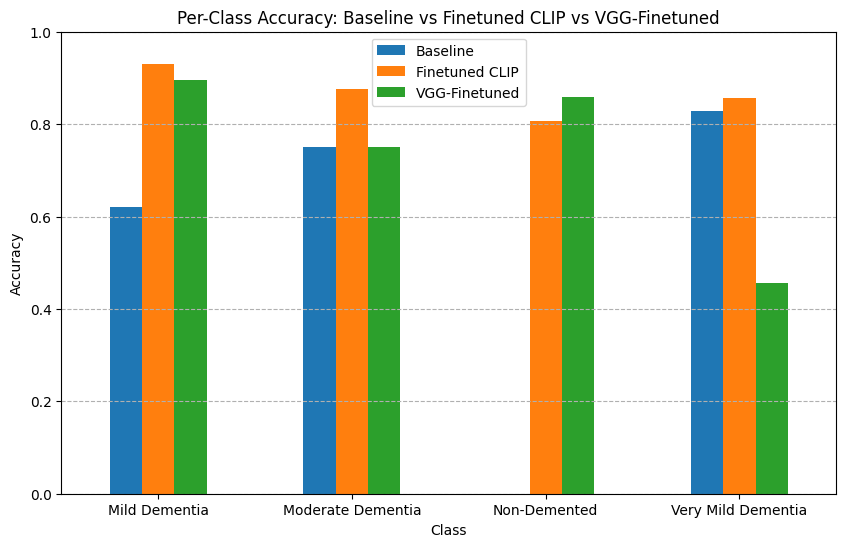

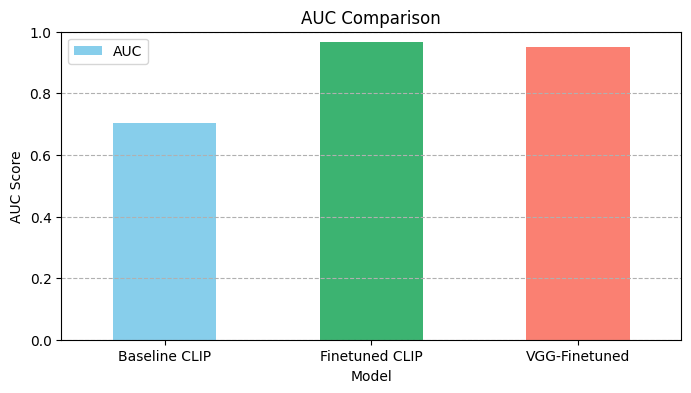

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


all_y_vgg, all_p_vgg, all_prob_vgg = [], [], []
vgg.eval()
image_proj.eval()
classifier_vgg.eval()

with torch.no_grad():
    for images, captions, labels in val_loader:
        images, captions = images.to(device), captions.to(device)
        feats   = vgg.features(images)
        pooled  = vgg.avgpool(feats)
        emb_i   = image_proj(pooled)                    
        emb_t   = model.encode_text(captions)          
        logits  = classifier_vgg(torch.cat([emb_i, emb_t], dim=1))
        probs   = logits.softmax(dim=1).cpu().numpy()
        preds   = probs.argmax(axis=1)

        all_y_vgg   .extend(labels.cpu().numpy())
        all_p_vgg   .extend(preds)
        all_prob_vgg.extend(probs)

y_true_vgg = np.array(all_y_vgg)
y_pred_vgg = np.array(all_p_vgg)
y_prob_vgg = np.vstack(all_prob_vgg)

vgg_cm  = confusion_matrix(y_true_vgg, y_pred_vgg, labels=np.arange(num_classes))
vgg_acc = accuracy_score(y_true_vgg, y_pred_vgg)
vgg_auc = safe_auc(y_true_vgg, y_prob_vgg)

print("Confusion Matrix (Baseline CLIP prompts):")
print(baseline_cm, "\n")
print("Confusion Matrix (Finetuned CLIP):")
print(finetuned_cm, "\n")
print("Confusion Matrix (VGG-Finetuned):")
print(vgg_cm, "\n")

print("--- Comparative Results ---")
print(f"Baseline CLIP:    Accuracy = {baseline_acc:.4f}, AUC = {baseline_auc:.4f}")
print(f"Finetuned CLIP:   Accuracy = {finetuned_acc:.4f}, AUC = {finetuned_auc:.4f}")
print(f"VGG-Finetuned:    Accuracy = {vgg_acc:.4f}, AUC = {vgg_auc:.4f}")

df_cls = pd.DataFrame({
    'Class': unique_labels,
    'Baseline':               baseline_cm.diagonal()  / baseline_cm.sum(axis=1),
    'Finetuned CLIP':         finetuned_cm.diagonal() / finetuned_cm.sum(axis=1),
    'VGG-Finetuned':          vgg_cm.diagonal()       / vgg_cm.sum(axis=1),
})
print("\nPer-Class Accuracy Comparison:")
print(df_cls)

ax = df_cls.set_index('Class').plot(
    kind='bar', figsize=(10, 6)
)
ax.set_ylabel('Accuracy')
ax.set_title('Per-Class Accuracy: Baseline vs Finetuned CLIP vs VGG-Finetuned')
ax.set_ylim(0, 1)
ax.grid(True, axis='y', linestyle='--')
plt.xticks(rotation=0)
plt.show()

df_auc = pd.DataFrame({
    'Model': ['Baseline CLIP', 'Finetuned CLIP', 'VGG-Finetuned'],
    'AUC':   [baseline_auc,    finetuned_auc,    vgg_auc]
})
ax = df_auc.plot(
    x='Model', y='AUC', kind='bar', figsize=(8, 4),
    color=['skyblue', 'mediumseagreen', 'salmon']
)
ax.set_ylabel('AUC Score')
ax.set_title('AUC Comparison')
ax.set_ylim(0, 1)
ax.grid(True, axis='y', linestyle='--')
plt.xticks(rotation=0)
plt.show()



=== Prompt 1 ===
Baseline CM:
 [[29  0  0  0]
 [ 8  0  0  0]
 [57  0  0  0]
 [35  0  0  0]]
Acc = 0.2248, AUC = 0.5000

Finetuned CLIP CM:
 [[27  1  0  1]
 [ 0  7  0  1]
 [ 2  0 46  9]
 [ 0  0  5 30]]
Acc = 0.8527, AUC = 0.9654

VGG-Finetuned CM:
 [[24  1  2  2]
 [ 2  3  3  0]
 [51  1  5  0]
 [17 13  5  0]]
Acc = 0.2481, AUC = 0.5524

Per-Class Accuracies:
                     Baseline  Finetuned CLIP  VGG-Finetuned
Class                                                      
Mild Dementia            1.0        0.931034       0.827586
Moderate Dementia        0.0        0.875000       0.375000
Non-Demented             0.0        0.807018       0.087719
Very Mild Dementia       0.0        0.857143       0.000000 



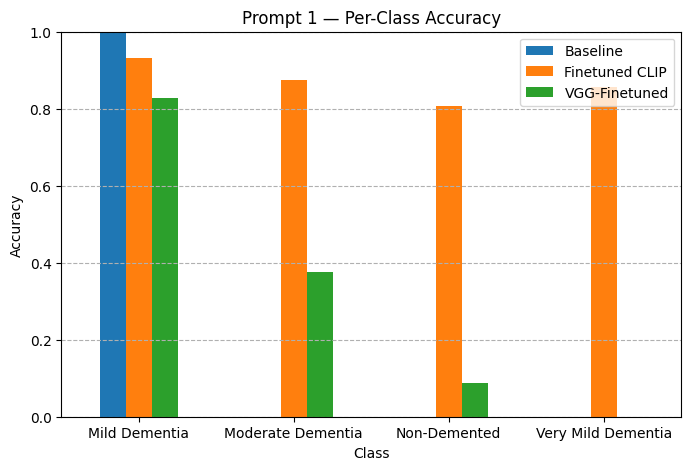

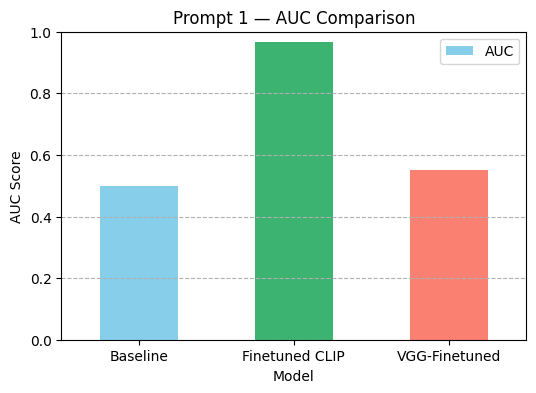


=== Prompt 2 ===
Baseline CM:
 [[11  0  0 18]
 [ 3  0  0  5]
 [34  0  0 23]
 [20  0  0 15]]
Acc = 0.2016, AUC = 0.4621

Finetuned CLIP CM:
 [[27  1  0  1]
 [ 0  7  0  1]
 [ 2  0 46  9]
 [ 0  0  5 30]]
Acc = 0.8527, AUC = 0.9654

VGG-Finetuned CM:
 [[24  1  2  2]
 [ 2  3  3  0]
 [51  1  5  0]
 [17 13  5  0]]
Acc = 0.2481, AUC = 0.5524

Per-Class Accuracies:
                     Baseline  Finetuned CLIP  VGG-Finetuned
Class                                                      
Mild Dementia       0.379310        0.931034       0.827586
Moderate Dementia   0.000000        0.875000       0.375000
Non-Demented        0.000000        0.807018       0.087719
Very Mild Dementia  0.428571        0.857143       0.000000 



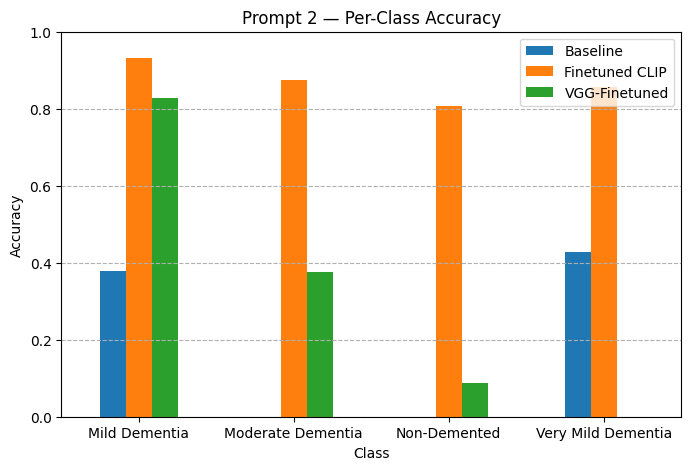

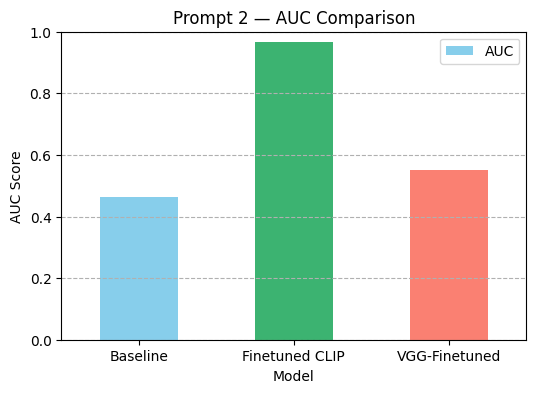


=== Prompt 3 ===
Baseline CM:
 [[ 3  1  0 25]
 [ 1  0  0  7]
 [ 4  2  0 51]
 [ 2  0  0 33]]
Acc = 0.2791, AUC = 0.5379

Finetuned CLIP CM:
 [[27  1  0  1]
 [ 0  7  0  1]
 [ 2  0 46  9]
 [ 0  0  5 30]]
Acc = 0.8527, AUC = 0.9654

VGG-Finetuned CM:
 [[24  1  2  2]
 [ 2  3  3  0]
 [51  1  5  0]
 [17 13  5  0]]
Acc = 0.2481, AUC = 0.5524

Per-Class Accuracies:
                     Baseline  Finetuned CLIP  VGG-Finetuned
Class                                                      
Mild Dementia       0.103448        0.931034       0.827586
Moderate Dementia   0.000000        0.875000       0.375000
Non-Demented        0.000000        0.807018       0.087719
Very Mild Dementia  0.942857        0.857143       0.000000 



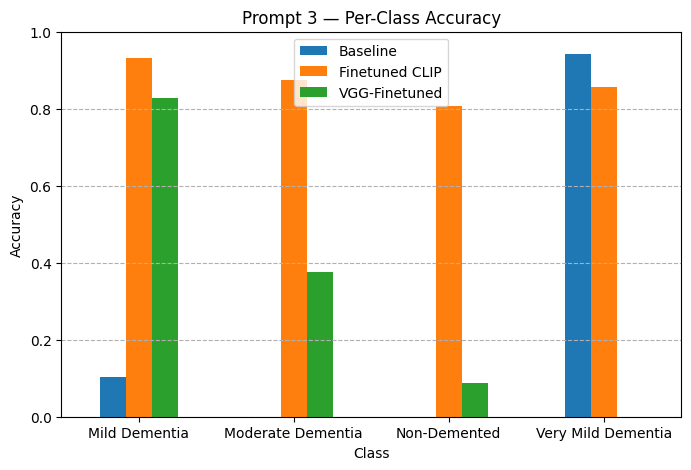

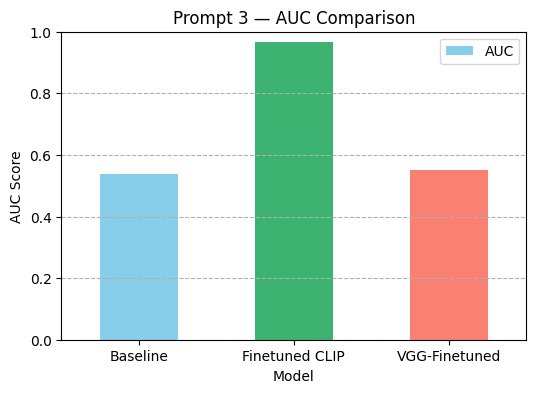

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix

base_model_untuned, _, _ = create_model_and_transforms(
    model_name=model_name,
    pretrained="checkpoints/open_clip_pytorch_model.bin",
    **{f"image_{k}": v for k, v in preprocess_cfg.items()}
)
base_model_untuned = base_model_untuned.to(device)
base_model_untuned.eval()

def safe_auc(y_true, y_prob):
    from sklearn.metrics import roc_auc_score
    aucs = []
    for i in range(num_classes):
        y_i = (y_true == i).astype(int)
        p_i = y_prob[:, i]
        if 0 < y_i.sum() < len(y_i):
            aucs.append(roc_auc_score(y_i, p_i))
    return float(np.mean(aucs)) if aucs else 0.0

def eval_baseline(prompts):
    ptoks = tokenizer(prompts).to(device)
    with torch.no_grad():
        p_embs = base_model_untuned.encode_text(ptoks)     
    ys, ps, Pr = [], [], []
    with torch.no_grad():
        for images, _, labels in val_loader:
            images = images.to(device)
            emb    = base_model_untuned.encode_image(images)
            sims   = (emb @ p_embs.T) * base_model_untuned.logit_scale.exp()
            probs  = sims.softmax(dim=1).cpu().numpy()
            preds  = probs.argmax(axis=1)
            ys.extend(labels.cpu().numpy())
            ps.extend(preds)
            Pr.extend(probs)
    return np.array(ys), np.array(ps), np.vstack(Pr)

def eval_with_classifier(model_, classifier_):
    ys, ps, Pr = [], [], []
    model_.eval(); classifier_.eval()
    with torch.no_grad():
        for images, captions, labels in val_loader:
            images, captions = images.to(device), captions.to(device)
            emb_i  = model_.encode_image(images)
            emb_t  = model_.encode_text(captions)
            logits = classifier_(torch.cat([emb_i, emb_t], dim=1))
            probs  = logits.softmax(dim=1).cpu().numpy()
            preds  = probs.argmax(axis=1)
            ys.extend(labels.cpu().numpy())
            ps.extend(preds)
            Pr.extend(probs)
    return np.array(ys), np.array(ps), np.vstack(Pr)

prompt_variants = {
    "Prompt 1": [
        f"The brain MRI scan of this patient is likely to be classified as {lab}."
        for lab in unique_labels
    ],
    "Prompt 2": [
        f"A medical expert looking to assess for a neuro-degenerative disease would likely classify this as {lab}."
        for lab in unique_labels
    ],
    "Prompt 3": [
        f"Based on the brain scan and given indicators, the patient most likely has the following diagnosis or stage of Alzheimer's disease: {lab}."
        for lab in unique_labels
    ]
}

for name, prompts in prompt_variants.items():
    print(f"\n=== {name} ===")
    # Baseline
    y0, p0, pb0 = eval_baseline(prompts)
    cm0 = confusion_matrix(y0, p0, labels=np.arange(num_classes))
    acc0, auc0 = accuracy_score(y0, p0), safe_auc(y0, pb0)
    print("Baseline CM:\n", cm0)
    print(f"Acc = {acc0:.4f}, AUC = {auc0:.4f}\n")

    # Finetuned CLIP
    y1, p1, pb1 = eval_with_classifier(model, classifier)
    cm1 = confusion_matrix(y1, p1, labels=np.arange(num_classes))
    acc1, auc1 = accuracy_score(y1, p1), safe_auc(y1, pb1)
    print("Finetuned CLIP CM:\n", cm1)
    print(f"Acc = {acc1:.4f}, AUC = {auc1:.4f}\n")

    # VGG-Finetuned
    y2, p2, pb2 = eval_with_classifier(model, classifier_vgg)
    cm2 = confusion_matrix(y2, p2, labels=np.arange(num_classes))
    acc2, auc2 = accuracy_score(y2, p2), safe_auc(y2, pb2)
    print("VGG-Finetuned CM:\n", cm2)
    print(f"Acc = {acc2:.4f}, AUC = {auc2:.4f}\n")

    # Per-class accuracy bar plot
    df_cls = pd.DataFrame({
        'Class': unique_labels,
        'Baseline':      cm0.diagonal() / cm0.sum(axis=1),
        'Finetuned CLIP': cm1.diagonal() / cm1.sum(axis=1),
        'VGG-Finetuned':  cm2.diagonal() / cm2.sum(axis=1),
    }).set_index('Class')
    print("Per-Class Accuracies:\n", df_cls, "\n")
    ax = df_cls.plot.bar(figsize=(8,5))
    ax.set_ylim(0,1); ax.set_ylabel('Accuracy')
    ax.set_title(f"{name} — Per-Class Accuracy"); ax.grid(axis='y', linestyle='--')
    plt.xticks(rotation=0)
    plt.show()

    # AUC comparison bar plot
    df_auc = pd.DataFrame({
        'Model': ['Baseline', 'Finetuned CLIP', 'VGG-Finetuned'],
        'AUC':   [auc0,        auc1,              auc2]
    })
    ax = df_auc.plot.bar(x='Model', y='AUC', figsize=(6,4), color=['skyblue','mediumseagreen','salmon'])
    ax.set_ylim(0,1); ax.set_ylabel('AUC Score')
    ax.set_title(f"{name} — AUC Comparison"); ax.grid(axis='y', linestyle='--')
    plt.xticks(rotation=0)
    plt.show()


# GradCAM Visualisation (Finetuned CLIP Model)

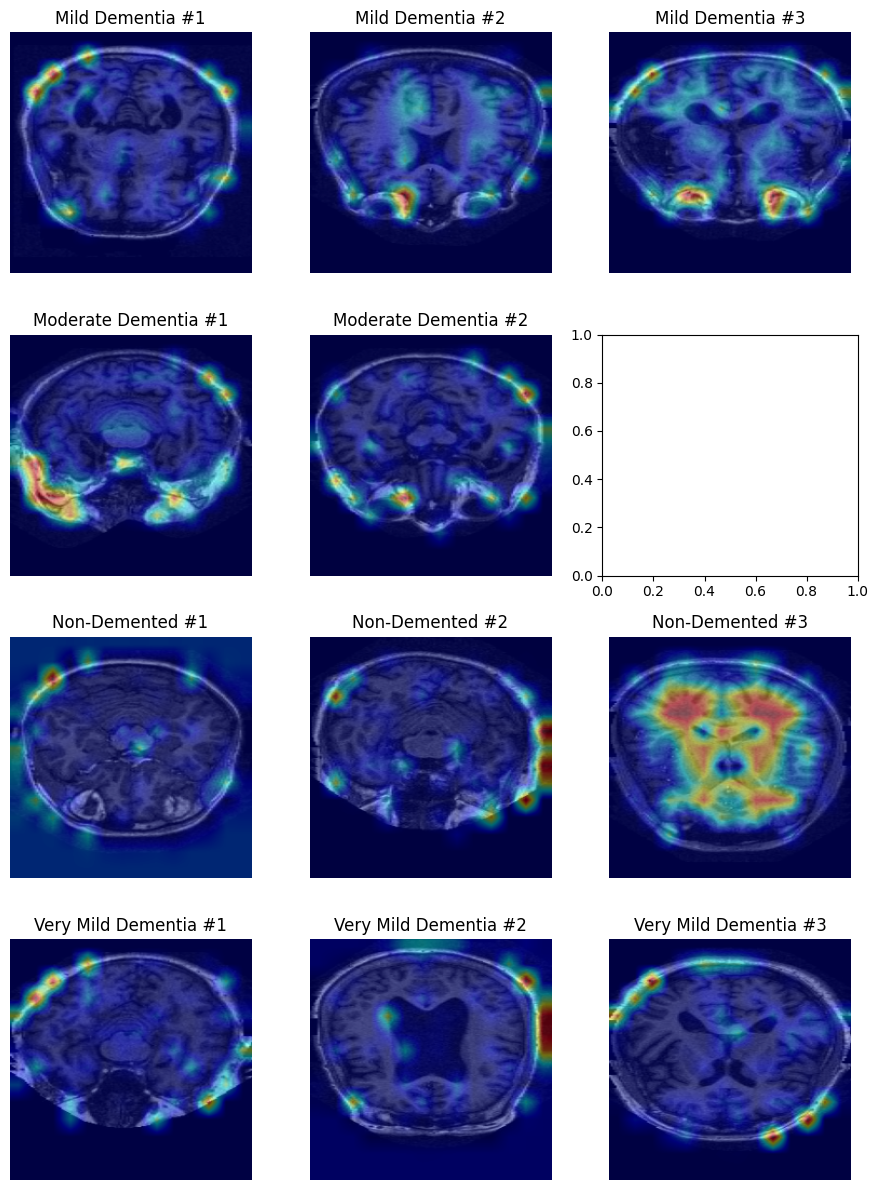

In [ ]:

from pytorch_grad_cam import EigenCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
import torch.nn as nn

target_layer_cl = model.visual.trunk.patch_embed.proj

class CLIPCamWrapper(nn.Module):
    def __init__(self, clip_model, classifier, text_emb):
        super().__init__()
        self.clip = clip_model
        self.classifier = classifier
        self.text_emb = text_emb

    def forward(self, x):
        feats   = self.clip.visual.trunk(x)          
        img_emb = self.clip.visual.head(feats)       
        txt_emb = self.text_emb.expand(img_emb.size(0), -1)
        return self.classifier(torch.cat([img_emb, txt_emb], dim=1))
        
central_examples = {c: [] for c in range(num_classes)}
for idx, row in train_ds.df.iterrows():
    cls = row['label_idx']
    if len(central_examples[cls]) >= 3:
        continue
    pid  = row['ID']
    imgs = id_to_images[pid]
    mid  = len(imgs) // 2
    if row['image_path'] == imgs[mid]:
        img_t, cap_t, _ = train_ds[idx]
        central_examples[cls].append((img_t.unsqueeze(0).to(device),
                                      cap_t.unsqueeze(0).to(device)))
    if all(len(v) >= 3 for v in central_examples.values()):
        break

fig, axes = plt.subplots(num_classes, 3, figsize=(3*3, num_classes*3))
for cls in range(num_classes):
    for j, (img_t, cap_t) in enumerate(central_examples[cls]):
        with torch.no_grad():
            text_emb = model.encode_text(cap_t)  
            
        wrapper = CLIPCamWrapper(model, classifier, text_emb).to(device)
        cam     = EigenCAM(model=wrapper, target_layers=[target_layer_cl])
        gray    = cam(input_tensor=img_t)[0]  
        
        np_img  = img_t.squeeze().permute(1,2,0).cpu().numpy()
        np_img  = (np_img - np_img.min())/(np_img.max()-np_img.min())
        cam_img = show_cam_on_image(np_img, gray, use_rgb=True, image_weight=0.6)
        ax = axes[cls, j]
        ax.imshow(cam_img)
        ax.axis('off')
        ax.set_title(f"{unique_labels[cls]} #{j+1}")
plt.tight_layout()
plt.show()


# GradCAM Visualisation (Finetuned VGG-Based Model)

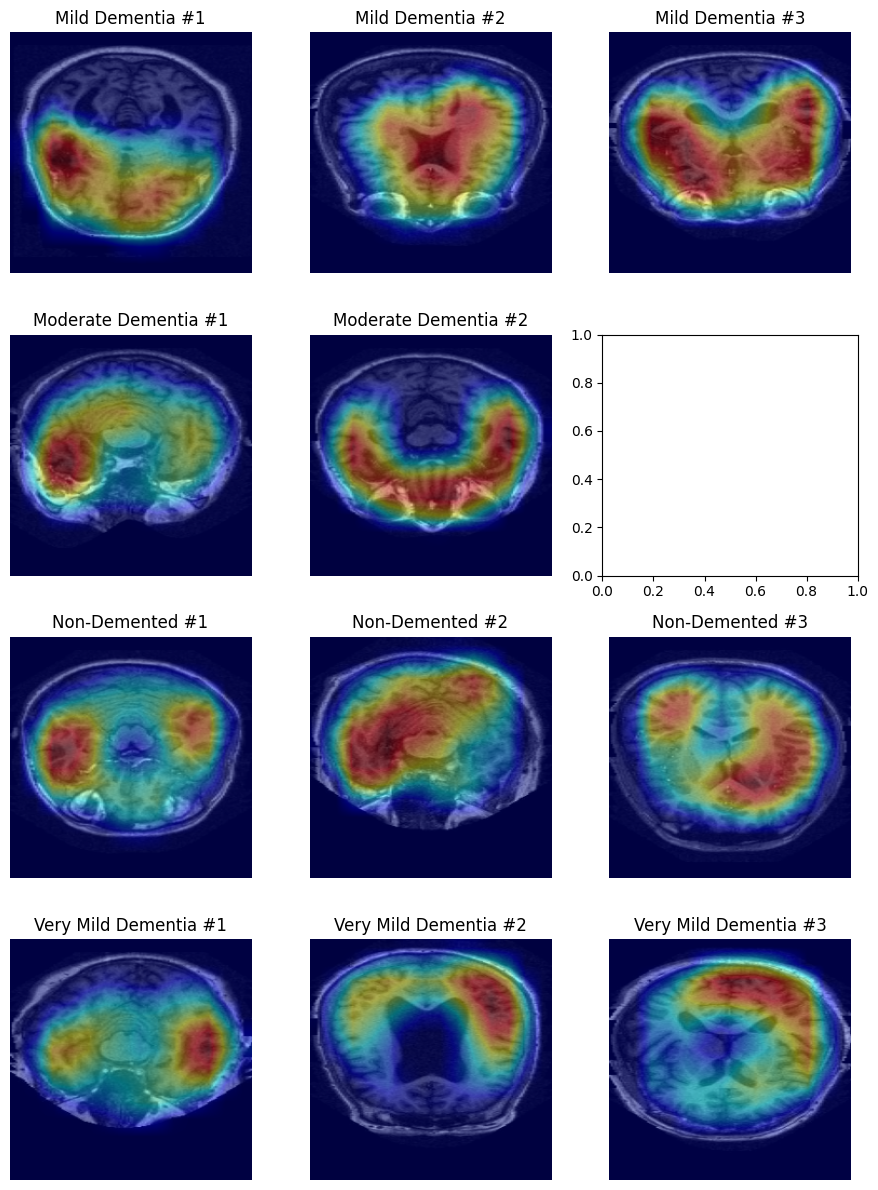

In [ ]:
from pytorch_grad_cam import EigenCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
import torch.nn as nn

target_layer_vgg = vgg.features[28]

class VGGCamWrapper(nn.Module):
    def __init__(self, vgg_model, image_proj, classifier, text_emb):
        super().__init__()
        self.vgg         = vgg_model
        self.image_proj  = image_proj
        self.classifier  = classifier
        self.text_emb    = text_emb

    def forward(self, x):
        feats   = self.vgg.features(x)                   
        pooled  = self.vgg.avgpool(feats)                  
        img_emb = self.image_proj(pooled)                
        txt_emb = self.text_emb.expand(img_emb.size(0), -1) 
        return self.classifier(torch.cat([img_emb, txt_emb], dim=1))

fig, axes = plt.subplots(num_classes, 3, figsize=(3*3, num_classes*3))
for cls in range(num_classes):
    for j, (img_t, cap_t) in enumerate(central_examples[cls]):
        with torch.no_grad():
            text_emb = model.encode_text(cap_t)  

        wrapper_vgg = VGGCamWrapper(vgg, image_proj, classifier_vgg, text_emb).to(device)
        cam_vgg     = EigenCAM(model=wrapper_vgg, target_layers=[target_layer_vgg])

        gray = cam_vgg(input_tensor=img_t)[0] 
        
        np_img = img_t.squeeze().permute(1,2,0).cpu().numpy()
        np_img = (np_img - np_img.min())/(np_img.max()-np_img.min())

        cam_img = show_cam_on_image(np_img, gray, use_rgb=True, image_weight=0.6)

        ax = axes[cls, j]
        ax.imshow(cam_img)
        ax.axis('off')
        ax.set_title(f"{unique_labels[cls]} #{j+1}")

plt.tight_layout()
plt.show()


# Takeaways



*   Finetuning the Model by adding a classification head and unfreezing the final two transformer blocks leads to significant gains in accuracy and related metrics for multiclass classification (detecting stages of dementia caused by Alzheimer's Disease).


*   However, the GradCAM visualisations clearly demonstrate a lack of explainability, the model generally is 'looking' at irrelevant areas of the MRI around the boundary region

*   We replace the vision head with VGG-16, which results in comparable overall accuracy without using any prompting beyond the custom captions.

*   The VGG-based model suffers greatly when prompts are passed to the model; but demonstrate much greater explainability in the GradCAM heatmaps


*   An issue that remains is that the prompts seem to be having a negligible effect on results, and our custom classifier is almost solely dependent on the image embeddings while seeming to ignore the text embeddings. Finetuning the text embedding head in parallel may be a prospective solution



